In [1]:
from itertools import product
import seaborn as sns
import statsmodels.api as sm
from sklearn import decomposition, preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chisquare, ks_1samp, ks_2samp, norm, chi2_contingency

# Nettoyage
La base de données nettoyée a été stocké dans un fichier, qu'on va lire.

In [2]:
data = pd.read_csv('data_cleaned_imputed.csv', sep='\t', index_col=0)

/home/ilyes/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


On re-définit les variables contenant les noms des colonnes quantitatives et qualitatives.

In [3]:
cols_quantity = pd.Index(['energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
                         'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g',
                          'nutrition-score-fr_100g', 'additives_n', 'ingredients_from_palm_oil_n',
                         'ecoscore_score_fr', 'serving_quantity', 'nova_group'])

In [4]:
cols_quality = ['main_category_en', 'pnns_groups_2', 'pnns_groups_1', 'additives_en']

# Exploration

## Analyses univariées
On va analyser chaque variable intéressante indépendamment. On va notamment analyser la dispersion, les valeurs centrales, mais aussi la forme des données et la distribution des variables. Pour valider un modèle de distribution, on tolère un R2 d'un minimum de 0.9.

### Nutri-score

Écart-type: 8.81


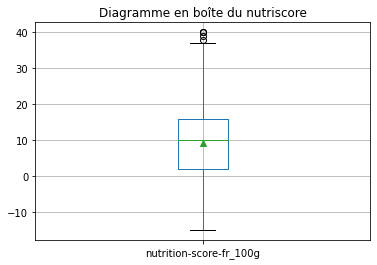

In [6]:
data[['nutrition-score-fr_100g']].boxplot(showmeans=True)
plt.title('Diagramme en boîte du nutriscore')
print("Écart-type: %.2f" % data['nutrition-score-fr_100g'].std())

- La moyenne/médiane est de 10, ce qui correspond à la note 'C'. Les produits sont donc en moyenne de qualité modérée, selon le nutri-score.
- 50% des produits sont environ entre 0 et 15, ce qui correspond aux notes entre B et D. Les autres 50% remplissent les valeurs plus extrêmes, ce qui abouti à un diagramme qui recouvre presque l'ensemble du spectre des notes possibles.

Voyons qui sont les outliers:

In [7]:
Q1 = data['nutrition-score-fr_100g'].quantile(0.25)
Q3 = data['nutrition-score-fr_100g'].quantile(0.75)
IQR = abs(Q3-Q1)
outliers = data[data['nutrition-score-fr_100g'] > Q3+1.5*IQR]
outliers = outliers.sort_values('nutrition-score-fr_100g')
outliers[['nutrition-score-fr_100g', 'main_category_en', 'product_name']]

,nutrition-score-fr_100g,main_category_en,product_name
1624179,38.0,waters,acqua
1781412,39.0,low mineral bottled waters,agua
659388,40.0,beverages,granulowany napój herbaciany
1259955,40.0,bonbons,walnut
1870218,40.0,green teas,matcha latte - green tea


On observe que parmi les produits avec le pire nutri-score, il y en a un qui fait partie de la catégorie 'waters', ce qui est étonnant. Vérifions ses valeurs nutritionnelles.

In [8]:
data.loc[1624179][cols_quantity]

energy-kcal_100g               396.0
fat_100g                        24.0
saturated-fat_100g              22.0
carbohydrates_100g              36.0
sugars_100g                     21.0
fiber_100g                     1.125
proteins_100g                   22.0
salt_100g                        2.0
sodium_100g                      0.8
nutrition-score-fr_100g         38.0
additives_n                      8.0
ingredients_from_palm_oil_n      0.0
ecoscore_score_fr               40.0
serving_quantity               102.9
nova_group                       1.0
Name: 1624179, dtype: object

Voyons si la distribution des nutri-score suit la somme de lois normales définie plus bas.

In [117]:
from scipy.stats import norm
# nutriscore: Contient les données pour le nutriscore
nutriscore = data['nutrition-score-fr_100g']
# nutriscore1: Contient le données pour la première loi normale de la somme
nutriscore1 = nutriscore[nutriscore <= 8]
# nutriscore2: Contient les données pour la 2ème loi normale de la somme
nutriscore2 = nutriscore[nutriscore > 8]
# mu1, std1: Les paramètres de la première loi normale de la somme
mu1, std1 = nutriscore1.mean(), nutriscore1.std()
# mu2, std2: Les paramètres de la deuxième loi normale de la somme
mu2, std2 = nutriscore2.mean(), nutriscore2.std()
# X: Ordonnée pour l'affiche de la distribution des nutriscores
X = np.sort(nutriscore.unique())
# normale1, normale2: Les lois normales composants la loi que suit le nutriscore, par hypothèse
normal1 = norm.pdf(X, mu1, std1)*len(nutriscore1)
normal2 = norm.pdf(X, mu2, std2)*len(nutriscore2)
normal = normal1+normal2
nutriscore = data[['nutrition-score-fr_100g', 'code']].groupby('nutrition-score-fr_100g').count()['code']

Text(0, 0.5, 'Nombre de produits')

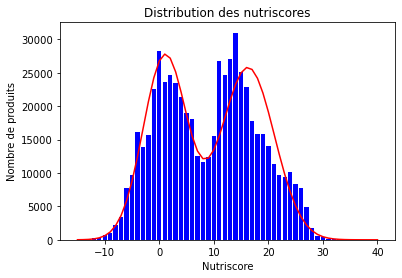

In [10]:
plt.bar(X, nutriscore, color='b')
plt.plot(X, normal, color='r')
plt.title('Distribution des nutriscores')
plt.xlabel('Nutriscore')
plt.ylabel('Nombre de produits')

Pour les tests statistique, on pose les hypothèses:
- H0: Les deux distributions sont les mêmes
- H1: Les deux distributions sont différentes

Le risque d'erreur qu'on est prêt à prendre est de 10%

On peut évaluer l'adéquation du modèle à l'observation en calculant le R2.

In [257]:
def calculate_R2(vals_obs, vals_exp):
    """Retourne le R2 entre des valeurs observées et des valeur attendues"""
    mean_exp = vals_exp.mean()
    # SSR: Somme des carrés résiduels
    SSR = ((vals_obs-vals_exp)**2).sum()
    # SST: Somme des carrés totale
    SST = ((vals_exp-mean_exp)**2).sum()
    return 1-SSR/SST

Si le R2 > 0.9, on considèrera que les distributions sont les mêmes.

In [258]:
r2 = calculate_R2(nutriscore, normal)
print("Le R2 trouvé pour le modèle du nutriscore est: %.2f" % r2)

Le R2 trouvé pour le modèle du nutriscore est: 0.88


D'après ce calcul, notre modèle n'est pas fidèle aux observations.

In [118]:
ks_2samp(nutriscore, normal)

KstestResult(statistic=0.07142857142857142, pvalue=0.9990634583594054)

On rejette l'hypothèse H0 avec un rique <1%.

**Conclusion**: On a pas trouvé la loi exacte pour le nutri-score. En revanche, il est sûr, d'après le diagramme en boîte, que les nutri-score sont assez faiblement dispersés autour des valeurs centrales. En conséquence, on trouvera assez peu d'alternatives si on part de valeurs extrêmes de nutri-score.

### Écoscore

Écart-type: 22.31


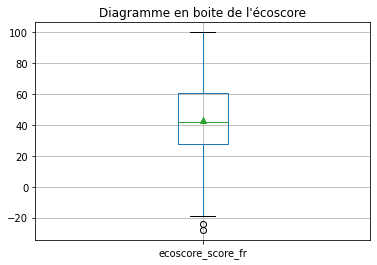

In [7]:
data[['ecoscore_score_fr']].boxplot(showmeans=True)
plt.title("Diagramme en boite de l'écoscore")
print("Écart-type: %.2f" % data['ecoscore_score_fr'].std())

On constate que l'écoscore est plus uniforme parmi les produits que le nutriscore. En effet, 50% des produits on un score environ entre 30 et 60, ce qui correspond à une note entre C et D: Les scores sont globalement plus bas que pour le nutri-score. 

Voyons quels sont les produits qui sont exeptionnellement peu écolos.

In [15]:
Q1 = data['ecoscore_score_fr'].quantile(0.25)
Q3 = data['ecoscore_score_fr'].quantile(0.75)
IQR = abs(Q3-Q1)
outliers = data[data['ecoscore_score_fr'] < Q1-1.5*IQR]
outliers = outliers.sort_values('ecoscore_score_fr')
outliers[['ecoscore_score_fr', 'main_category_en', 'product_name']]

,ecoscore_score_fr,main_category_en,product_name
777854,-28.0,moussaka,moussaka
1320051,-24.0,moussaka,moussaka


In [8]:
ecoscore = data['ecoscore_score_fr']
X = np.sort(ecoscore.unique())
ecoscore = data[['ecoscore_score_fr', 'code']].groupby('ecoscore_score_fr').count()['code']

Text(0, 0.5, 'Effectifs')

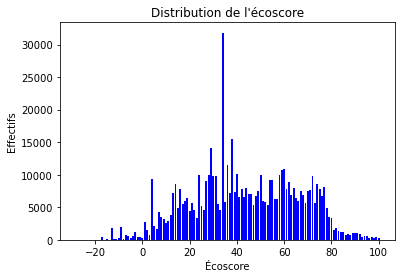

In [9]:
plt.bar(X, ecoscore, color='b')
plt.title("Distribution de l'écoscore")
plt.xlabel("Écoscore")
plt.ylabel("Effectifs")

On ne voit émerger aucune distribution à laquelle pourrait appartenir l'écoscore.

**Conclusion**: De manière similaire au nutri-score, on a pas trouvé la loi de distribution de l'écoscore. En revanche les mêmes remarques peuvent être faites en ce qui concerne la faible dispersio des données autour des valeurs centrales.

### Valeurs nutritionnelles

Écarts-types:
carbohydrates_100g    27.529284
fat_100g              18.668801
fiber_100g             3.877178
proteins_100g          8.963212
salt_100g              3.130362
saturated-fat_100g     8.133909
sugars_100g           18.516449
dtype: float64


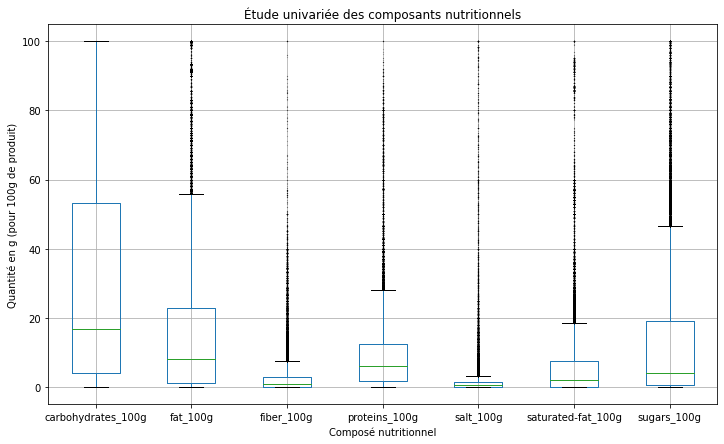

In [218]:
cols_nutrition = cols_quantity.difference(pd.Index(['nutrition-score-fr_100g', 'ecoscore_score_fr',
                                                   'energy-kcal_100g', 'additives_n', 'serving_quantity',
                                                   'ingredients_from_palm_oil_n', 'nova_group']))
plt.figure(figsize=(12, 7))
data[cols_nutrition].boxplot(flierprops={'markersize': .1})
plt.xlabel("Composé nutritionnel")
plt.ylabel("Quantité en g (pour 100g de produit)")
plt.title("Étude univariée des composants nutritionnels")
print("Écarts-types:\n%s" % data[cols_nutrition].std())

On peut faire plusieurs observation à partir de ces diagrammes.
- Les carbohydrates sont généralement présents en plus grande quantité que les autres composants (~20g en moyenne)
- Certains composants sont souvent présents en très faible quantité (le sel, les fibres: ~1g en moyenne)
- Pour presque tous les composants, il y à de nombreux outliers.

Cela est sûrement due à la variabilité de ces proportion selon les produits, leur catégorie... Par exemple, les viandes contiennent beaucoup plus de protéïne que la moyenne des aliments. De la même manière, les friandises contiennent plus de sucres et/ou de gras. Et les exemples sont nombreux.

### Fonction d'analyse de la distribution

In [11]:
# get_left_interval: Retourne la borne gauche d'un intervalle de Pandas
get_left_interval = lambda x: x.left
def discretize(data, var_name, n_intervals):
    """Étant donné une variable continue, la discrétise sur plusieurs intervalles."""
    categories = pd.cut(data[var_name], n_intervals)
    discrete_values = categories.map(get_left_interval).sort_values()
    return discrete_values.replace(-0.1, 0)

In [12]:
def plot_distribution(data, var_name, n_intervals=None):
    """Affiche l'histogramme de la distribution d'une variable."""
    values = data[var_name] if n_intervals is None else discretize(data, var_name, n_intervals)
    df_values = values.to_frame()
    df_values['x'] = [1]*len(df_values)
    count_var = df_values.groupby(var_name).count()['x']
    plt.bar(count_var.index, count_var)
    plt.title('Distribution empirique de \'%s\'' % var_name)
    plt.xlabel('Unité de  \'%s\'' % var_name)
    plt.ylabel('Nombre de produits')
    return count_var.index, count_var.values

In [13]:
def matches_geom_serie_dec(x, y):
    """Calcule le R2 de la correspondance de la fonction y(x) avec une série géométrique décroissante."""
    # On applique le logarithme à y pour obtenir X=x et Y tel que Y = a.X + b
    X = np.array(x)
    Y = np.log(y)
    X = X.reshape((len(X), 1))
    X = sm.add_constant(X)
    reg = sm.OLS(Y, X)
    res = reg.fit()
    print("Correspondance à une série géométrique décroissante: R2 = %.2f" % res.rsquared)
    print("p-values: %s" % (res.pvalues))

In [14]:
def matches_inv_func(x, y):
    """Calcule le R2 de la correspondance de la fonction y(x) avec une fonction inverse."""
    # On applique le logarithme à x et y pour obtenir X et Y tel que Y = a.X + b
    X = np.log(x)
    Y = np.log(y)
    X = X.reshape((len(X), 1))
    X = sm.add_constant(X)
    reg = sm.OLS(Y, X)
    res = reg.fit()
    print("Correspondance à une fonction inverse: R2 = %.2f" % res.rsquared)
    print("p-values: %s" % (res.pvalues))

In [15]:
def plot_lorenz_curve(var_values, var_name):
    """Affiche la courbe de Lorenz d'une variable et retourne l'indice de Gini"""
    sorted_values = var_values.sort_values()
    values_cum = sorted_values.cumsum()/sorted_values.sum()
    X = np.linspace(0, len(sorted_values), len(sorted_values))/len(sorted_values)
    plt.plot(X, X, color='r')
    plt.plot(X, values_cum)
    plt.title("Courbe de Lorenz de \'%s\'" % var_name)
    plt.xlabel("Numéro de produit")
    plt.ylabel("Ratio de la somme totale de \'%s\'" % var_name)
    integral = (values_cum.sum() - (values_cum.iloc[-1]+values_cum.iloc[0])/2)/len(values_cum)
    return 2*(.5-integral)

**Sel**

H0: Coeffs nuls => aucun impact

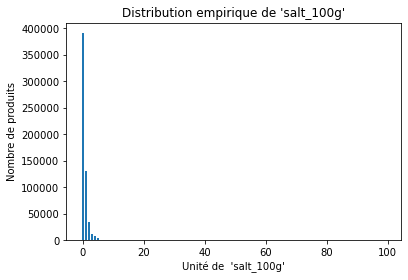

In [16]:
X, Y = plot_distribution(data, 'salt_100g', 100)

In [260]:
matches_inv_func([x+1 for x in X], [y+1 for y in Y])

Correspondance à une fonction inverse: R2 = 0.91
p-values: [3.79114674e-66 9.02705437e-53]


indice de Gini:


0.6613012422027893

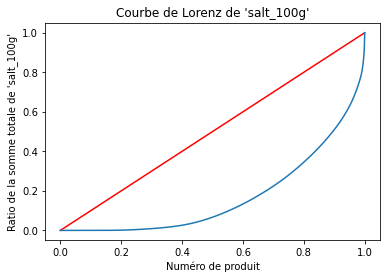

In [17]:
print("indice de Gini:")
plot_lorenz_curve(data['salt_100g'], 'salt_100g')

**Protéïnes**

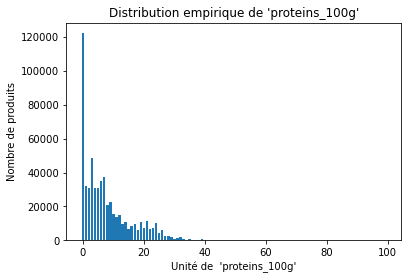

In [18]:
X, Y = plot_distribution(data, 'proteins_100g', 100)

In [203]:
matches_geom_serie_dec(X, [y+1 for y in Y])

Correspondance à une série géométrique décroissante: R2 = 0.90
p-values: [6.08883107e-77 1.66778679e-51]


indice de Gini:


0.5333597322794514

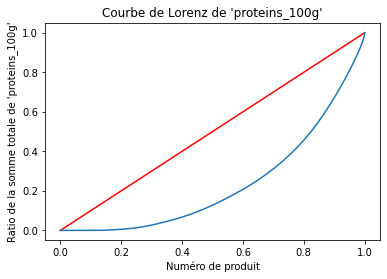

In [19]:
print("indice de Gini:")
plot_lorenz_curve(data['proteins_100g'], 'proteins_100g')

**Fibres**

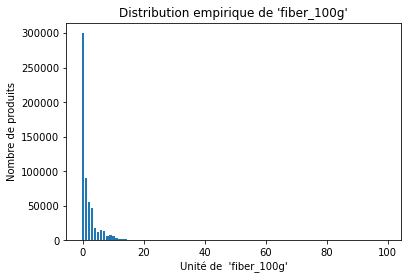

In [204]:
X, Y = plot_distribution(data, 'fiber_100g', 100)

In [205]:
matches_inv_func([x+1 for x in X], [y+1 for y in Y])

Correspondance à une fonction inverse: R2 = 0.93
p-values: [1.52852267e-67 2.24742247e-58]


indice de Gini:


0.6847967851012753

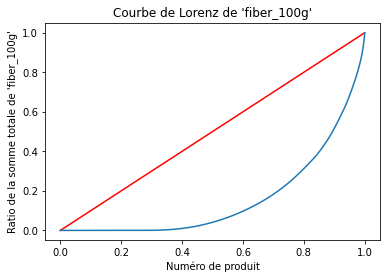

In [34]:
print("indice de Gini:")
plot_lorenz_curve(data['fiber_100g'], 'fiber_100g')

**Sucre**

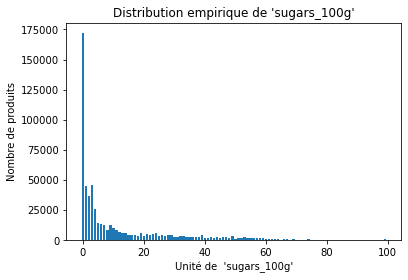

In [20]:
X, Y = plot_distribution(data, 'sugars_100g', 100)

La forme de la distribution nous rappelle celle de la fonction inverse. Voyons si elle y correspond

In [207]:
matches_inv_func([x+1 for x in X], Y)

Correspondance à une fonction inverse: R2 = 0.80
p-values: [3.54324114e-66 1.57980201e-35]


Ici, la distribution se rapproche d'une fonction inverse. Cependant: R2 = 0.8 < 0.95. On en conclu que la distribution de la quantité de sucre ne suit pas une loi inverse.   
On peut vérifier si elle suit une loi inverse par morceaux , comme on voit une variation importante de la courbe en x=10.

In [208]:
matches_inv_func([x+1 for x in X][:10], Y[:10])

Correspondance à une fonction inverse: R2 = 0.92
p-values: [9.13355439e-12 1.25943999e-05]


In [212]:
matches_geom_serie_dec(X[10:], Y[10:])

Correspondance à une série géométrique décroissante: R2 = 0.88
p-values: [3.62685423e-85 1.41548147e-41]


Même en segmentant la fonction, on ne trouve pas sa distribution.

Une chose est sûre, les produits sont concentrés à l'origine de la distribution. Voyons en détails:

indice de Gini:


0.6732526016884971

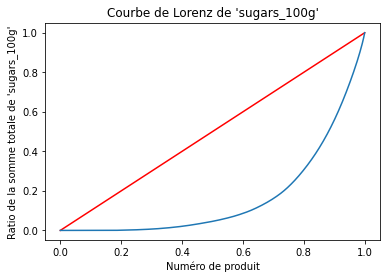

In [38]:
print("indice de Gini:")
plot_lorenz_curve(data['sugars_100g'], 'sugars_100g')

La répartition du sucre parmi les produits est donc plutôt inégalitaire. En effet, 80% des produits les plus pauvres en sucre ne contiennent que 30% de la quantité totale de sucre environ.

**Matière grasse**

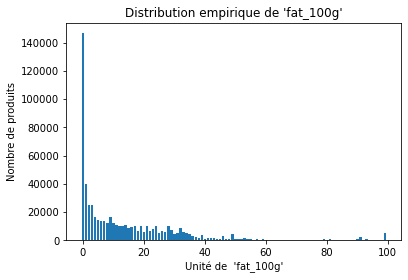

In [213]:
X, Y = plot_distribution(data, 'fat_100g', 100)

In [219]:
matches_geom_serie_dec(X, Y)

Correspondance à une série géométrique décroissante: R2 = 0.79
p-values: [5.77862544e-76 3.57412748e-35]


In [222]:
matches_inv_func([x+1 for x in X][:30], Y[:30])

Correspondance à une fonction inverse: R2 = 0.85
p-values: [5.06173519e-34 3.25736099e-13]


In [224]:
matches_inv_func([x+1 for x in X][30:], Y[30:])

Correspondance à une fonction inverse: R2 = 0.59
p-values: [2.37648975e-21 1.27118268e-14]


indice de Gini:


0.6106064959217847

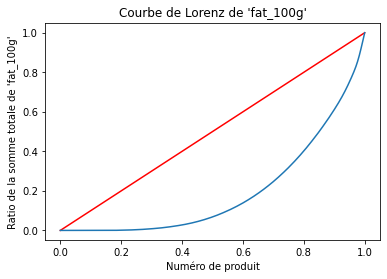

In [42]:
print("indice de Gini:")
plot_lorenz_curve(data['fat_100g'], 'fat_100g')

**Nombre d'additifs**

In [225]:
additives_n = data['additives_n']
Y = data[['additives_n', 'code']].groupby('additives_n').count()['code']
X = Y.index

Text(0, 0.5, 'Nombre de produits')

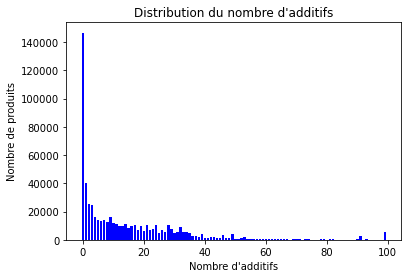

In [195]:
plt.bar(X, Y, color='b')
plt.title('Distribution du nombre d\'additifs')
plt.xlabel('Nombre d\'additifs')
plt.ylabel('Nombre de produits')

In [226]:
matches_geom_serie_dec(X, Y)

Correspondance à une série géométrique décroissante: R2 = 0.98
p-values: const    9.780418e-51
x1       6.329969e-39
dtype: float64


indice de Gini:


0.5490474522931619

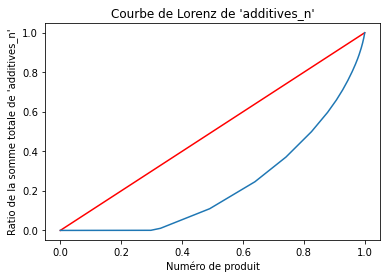

In [47]:
print("indice de Gini:")
plot_lorenz_curve(data['additives_n'], 'additives_n')

**Carbohydrates**

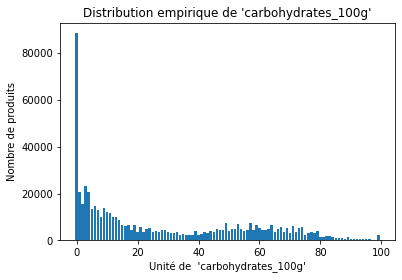

In [227]:
X, Y = plot_distribution(data, 'carbohydrates_100g', 100)

In [228]:
matches_inv_func([x+1 for x in X], Y)

Correspondance à une fonction inverse: R2 = 0.60
p-values: [1.04886061e-66 5.63700705e-21]


In [229]:
matches_inv_func([x+1 for x in X][:40], Y[:40])

Correspondance à une fonction inverse: R2 = 0.90
p-values: [7.28256989e-45 5.96945791e-21]


In [230]:
Yp = Y[40:]
ks_1samp((Yp-Yp.mean())/Yp.std(), cdf=norm.cdf)

KstestResult(statistic=0.11034477698255046, pvalue=0.4274750486558323)

Le test de Kolmogorov-Smirnov nous assure que la deuxième partie de la distribution ne correspond pas à une loi normale (p-value<0.9)

indice de Gini:


0.533729079012017

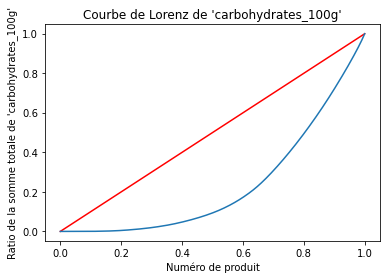

In [51]:
print("indice de Gini:")
plot_lorenz_curve(data['carbohydrates_100g'], 'carbohydrates_100g')

**Conclusion pour les valeurs nutritionnelles:** Les distributions des valeurs nutritionnelles décroient assez fortement, selon une loi inverse, ou exponentiellement, de façon générale. Comme on l'a vérifié avec la courbe de Lorenz, la quantité de ces composant est assez concentrée sur certains produits, avec un indice de Gini autour de 0.5 au minimum. Par conséquent:
- Le nombre d'alternatives est faible pour des grandes quantité d'un composants
- Il y à beaucoup d'alternatives lorsque les quantités sont faibles. 

**Nombre d'ingrédients issus de l'huile de palme**

In [52]:
Y = data[['ingredients_from_palm_oil_n', 'code']].groupby('ingredients_from_palm_oil_n').count()['code']
X = Y.index

Text(0, 0.5, 'Nombre de produits')

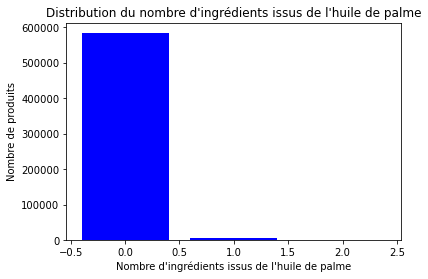

In [53]:
plt.bar(X, Y, color='b')
plt.title('Distribution du nombre d\'ingrédients issus de l\'huile de palme')
plt.xlabel('Nombre d\'ingrédients issus de l\'huile de palme')
plt.ylabel('Nombre de produits')

La très grande majorité des produits ne contiennent pas d'ingrédients issus de l'huile de palme. C'est donc un mauvais indicateur pour comparer les produits entre eux.

**Groupe Nova**

In [10]:
Y = data[['nova_group', 'code']].groupby('nova_group').count()['code']
X = Y.index

Text(0, 0.5, 'Nombre de produits')

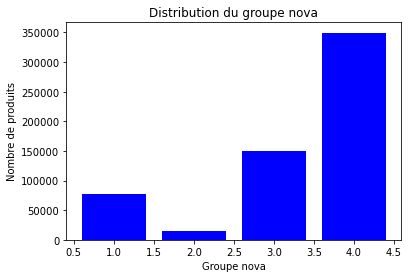

In [55]:
plt.bar(X, Y, color='b')
plt.title('Distribution du groupe nova')
plt.xlabel('Groupe nova')
plt.ylabel('Nombre de produits')

Plus de la moitié de produits sont ultra-transformés. Si on veut diminuer le niveau de transformation d'un produit, on aura significativement moins d'alternatives.

**Catégorie principale**

In [22]:
def plot_distribution_categ(group_name):
    # size_main_categs: Taille de l'effectif pour chaque catégorie principale
    size_categs = data.groupby(group_name).count()['code'].sort_values(ascending=False)
    # num_categ: Numéro attribué à chaque catégorie principale
    num_categ = [i for i in range(1,len(size_categs)+1)]
    # On affiche l'histogramme des effectifs par catégorie principale
    plt.bar(num_categ, size_categs, width=2)
    plt.xlabel('Numéro catégorie')
    plt.ylabel('effectifs')
    plt.title("Effectifs par catégorie dans %s" % group_name)
    return num_categ, size_categs

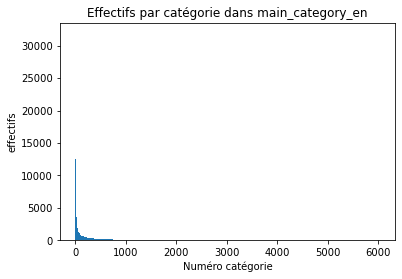

In [14]:
X, Y = plot_distribution_categ('main_category_en')

(0.0, 500.0)

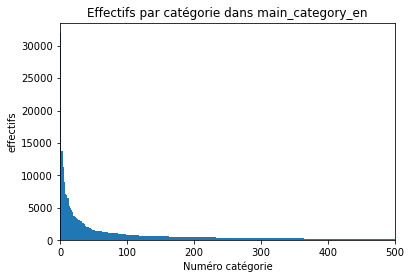

In [231]:
X, Y = plot_distribution_categ('main_category_en')
plt.xlim(0, 500)

In [233]:
matches_geom_serie_dec(X, Y)

Correspondance à une série géométrique décroissante: R2 = 0.93
p-values: const    0.0
x1       0.0
dtype: float64


0.883176826892367

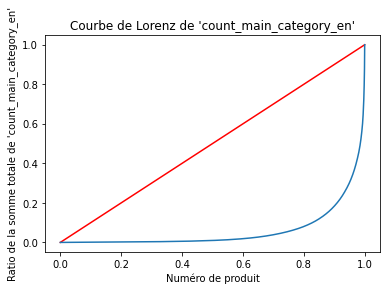

In [15]:
plot_lorenz_curve(Y, 'count_main_category_en')

Le nombre de produits par catégorie décroit exponentiellement. Pour la très grande majorité, elles contiennent très peu de produits. En effet, près de 90% des produits sont concentrés sur 20% des catégories. Dans la plus part des cas, il sera donc difficile de trouver des alternatives dans la même catégorie principale.

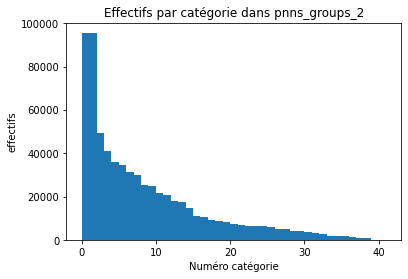

In [23]:
X, Y = plot_distribution_categ('pnns_groups_2')

In [235]:
matches_inv_func(X, Y)

Correspondance à une fonction inverse: R2 = 0.65
p-values: const    7.757013e-26
x1       3.765927e-10
dtype: float64


In [236]:
matches_inv_func(X[:15], Y.iloc[:15])

Correspondance à une fonction inverse: R2 = 0.94
p-values: const    2.748885e-21
x1       3.011346e-09
dtype: float64


In [24]:
x = X[15:]
y = Y.iloc[15:]
x = np.array(x).reshape((len(x), 1))
x = sm.add_constant(x)
reg = sm.OLS(y, x)
res = reg.fit()
print("Correspondance à une droite: R2 = %.2f" % res.rsquared)
print("p-values: %s" % (res.pvalues))

Correspondance à une droite: R2 = 0.98
p-values: const    2.088738e-25
x1       2.200564e-22
dtype: float64


0.5616869114789864

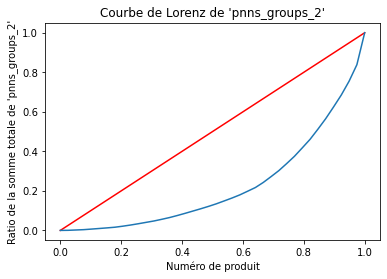

In [12]:
plot_lorenz_curve(Y, 'pnns_groups_2')

Lorsqu'on passe au niveau de catégories supérieur, la décroissance est moins forte (linéaire à partir de la 15ème catégorie). Cela se traduit par un indice de Gini plus faible: 0.56, contre 0.88 pour la catégorie principale.
On aura donc plus de choix en choisissant une catégorie de niveau plus élevé.

Lorsqu'on

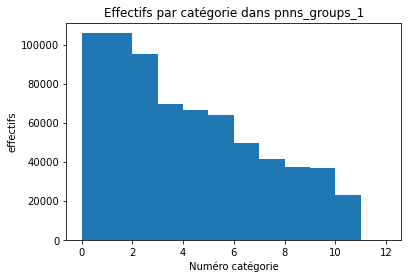

In [245]:
X, Y = plot_distribution_categ('pnns_groups_1')

In [246]:
X = np.array(X).reshape((len(X), 1))
X = sm.add_constant(X)
reg = sm.OLS(Y, X)
res = reg.fit()
print("Correspondance à une droite: R2 = %.2f" % res.rsquared)
print("pvalues: %s" %(res.pvalues))

Correspondance à une droite: R2 = 0.95
pvalues: const    2.437405e-09
x1       3.403304e-07
dtype: float64


0.3069795826161891

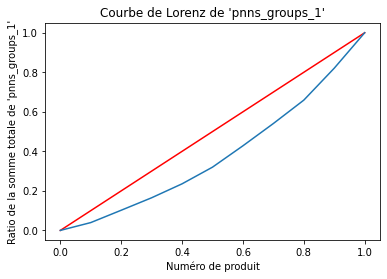

In [14]:
plot_lorenz_curve(Y, 'pnns_groups_1')

On étend la précédente observation au niveau de catégories encore au dessus, pour lequel la répartition des produits est beaucoup plus homogène.

### Analyse univariée par catégorie

Voyons comment varie le nutri-score en fonction de la catégorie principale des aliments.

In [8]:
def statistics_per_categ(group_name, var_name):
    # indics_categs: Va contenir les indicateurs statistiques principaux par catégorie
    indics_categs = data[[group_name, var_name]].groupby(group_name).mean()
    indics_categs.columns = ['mean']
    x = data[[group_name, var_name]].groupby(group_name).median()
    indics_categs['median'] = x[var_name]
    x = data[[group_name, var_name]].groupby(group_name).std()
    indics_categs['standard deviation'] = x[var_name]
    return indics_categs

Text(0.5, 1.0, 'Diagrammes en boîte pour les indicateurs par catégorie')

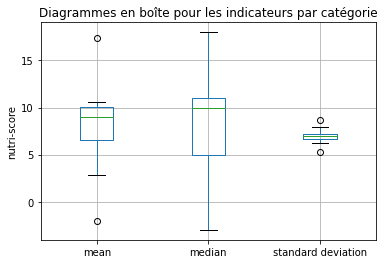

In [12]:
indics_categs = statistics_per_categ('pnns_groups_1', 'nutrition-score-fr_100g')
indics_categs.boxplot()
plt.ylabel('nutri-score')
plt.title('Diagrammes en boîte pour les indicateurs par catégorie')

In [17]:
Q1 = indics_categs['mean'].quantile(0.25)
Q3 = indics_categs['mean'].quantile(0.75)
IQR = abs(Q3-Q1)
outliers_std = indics_categs[(indics_categs['mean'] > Q3+1.5*IQR) | (indics_categs['mean'] < Q1-1.5*IQR)]
outliers_std.sort_values('mean', ascending=False)

,mean,median,standard deviation
pnns_groups_1,,,
sugary snacks,17.352981,18.0,6.612088
fruits and vegetables,-2.001691,-3.0,5.293326


## Corrélations entre les valeurs nutritionnelles

Voyons s'il existe des corrélations entre ces variables

In [111]:
data_corr = data[cols_quantity]

Vérifions cela avec la matrice des corrélations

In [112]:
data_corr.corr()

,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,additives_n,ingredients_from_palm_oil_n,ecoscore_score_fr,serving_quantity,nova_group
energy-kcal_100g,1.000000,0.800964,0.567740,0.406974,0.252708,0.254299,0.200414,-0.032344,-0.032346,0.546921,0.072202,0.076307,-0.332414,-0.479397,0.043255
fat_100g,0.800964,1.000000,0.683582,-0.127781,-0.070930,0.079174,0.149457,-0.012001,-0.012004,0.440321,-0.055578,0.036125,-0.370501,-0.292006,-0.026452
saturated-fat_100g,0.567740,0.683582,1.000000,-0.075697,0.053124,-0.019699,0.161671,-0.015102,-0.015103,0.561204,0.012099,0.059707,-0.355586,-0.245482,0.069726
carbohydrates_100g,0.406974,-0.127781,-0.075697,1.000000,0.660896,0.285340,-0.190668,-0.079300,-0.079298,0.254975,0.270761,0.084247,0.093103,-0.339997,0.129410
sugars_100g,0.252708,-0.070930,0.053124,0.660896,1.000000,0.022953,-0.285348,-0.111539,-0.111534,0.436117,0.270912,0.071426,-0.159677,-0.233999,0.223167
fiber_100g,0.254299,0.079174,-0.019699,0.285340,0.022953,1.000000,0.154697,-0.034269,-0.034271,-0.138215,-0.091496,0.009066,0.064719,-0.179769,-0.138074
proteins_100g,0.200414,0.149457,0.161671,-0.190668,-0.285348,0.154697,1.000000,0.102605,0.102604,0.081798,-0.132507,-0.022461,-0.368006,-0.210447,-0.033403
salt_100g,-0.032344,-0.012001,-0.015102,-0.079300,-0.111539,-0.034269,0.102605,1.000000,0.999995,0.145361,0.005795,-0.006839,-0.002786,-0.108553,0.087017
sodium_100g,-0.032346,-0.012004,-0.015103,-0.079298,-0.111534,-0.034271,0.102604,0.999995,1.000000,0.145365,0.005791,-0.006840,-0.002777,-0.108554,0.087015
nutrition-score-fr_100g,0.546921,0.440321,0.561204,0.254975,0.436117,-0.138215,0.081798,0.145361,0.145365,1.000000,0.331591,0.094089,-0.407470,-0.334600,0.413070


Les corrélations les plus intéressantes sont les suivantes.
- Entre le sel et le sodium
- Entre l'énergie et le gras: L'énergie est souvent sous forme de gras (0.8)
- Entre gras et gras saturé: Le gras est souvent sous sa forme saturée (0.68)

### Corrélation entre le sel et le sodium

La corrélation est très importante (0.999995). On supprime donc la variable du sodium.

In [113]:
data = data.drop(columns=['sodium_100g'])
cols_quantity = cols_quantity.difference(pd.Index(['sodium_100g']))

### Corrélation entre gras/sucre/protéïne/fibre/carbohydrates et énergie.

Ensuite, on observe que les diagrammes de dispersion pour l'énergie se rapprochent de plus en plus d'une droite, à mesure que la concentration en gras/sucre/protéïne/fibre augmente.  
En effet, plus la concentration en sucre/gras/protéïne/fibre est grande, plus la valeur énergétique du produit dépend de ce seul composant.   
En revanche, on peut se demander si la valeur énergétique d'un produit dépend de ses 4 seuls composants.   
Étudions cette question.

In [114]:
y = data_corr['energy-kcal_100g']
x = data_corr[['sugars_100g', 'fat_100g', 'proteins_100g', 'fiber_100g', 'carbohydrates_100g']].to_numpy()
x = x.reshape((len(x), 5))
x = sm.add_constant(x)
reg = sm.OLS(y, x)
res = reg.fit()
b, a = res.params[0], res.params[1]
print("Corrélation entre (gras, sucre, protéïne, fibre, carbohydrates) et valeur énergétique: R2 = %s" % res.rsquared)

Corrélation entre (gras, sucre, protéïne, fibre, carbohydrates) et valeur énergétique: R2 = 0.9356016228844118


On a trouvé un R2 très proche de 1. La corrélation est largement présente. On va donc supprimer la valeur calorique des variables étudiées.

In [115]:
data = data.drop(columns=['energy-kcal_100g'])
cols_quantity = cols_quantity.difference(pd.Index(['energy-kcal_100g']))

## ACP
Étudier les corrélations entre les variables 2 à 2 est assez pénible vu le nombre de variables.
On va réaliser une ACP. Cela nous permettra, d'une part, de vérifier plus aisément la présence de corrélations entre variables, et, d'autre part, de comparer nos produits selon plusieurs critères à la fois pour évaluer leur impact sur la santé.

On commence par sélectionner les variables quantitatives à utiliser pour l'analyse.

On ne garde pas le nombre d'ingrédients issus de l'huile de palme, car il n'est pas pertinent, comme on l'a vu lors de l'étude la distribution.

In [15]:
cols_quantity = cols_quantity.difference(pd.Index(['ingredients_from_palm_oil_n']))

In [16]:
print("Colonnes utilisée pour l'ACP:\n %s" % cols_quantity)

Colonnes utilisée pour l'ACP:
 Index(['additives_n', 'carbohydrates_100g', 'ecoscore_score_fr',
       'energy-kcal_100g', 'fat_100g', 'fiber_100g', 'nova_group',
       'nutrition-score-fr_100g', 'proteins_100g', 'salt_100g',
       'saturated-fat_100g', 'serving_quantity', 'sodium_100g', 'sugars_100g'],
      dtype='object')


In [17]:
data_acp = data[cols_quantity]

### Centrage-réduction

In [18]:
x_scaled = preprocessing.StandardScaler().fit_transform(data_acp.values)

### Composantes principales

Choix du nombre de composantes principales

In [19]:
n_components_values = np.arange(3,len(cols_quantity)+1)
dict_res = {}
for n_components in n_components_values:
    pca = decomposition.PCA(n_components=n_components)
    X_projected = pca.fit_transform(x_scaled)
    scree = pca.explained_variance_ratio_*100
    dict_res[n_components] = sum(scree)

In [20]:
print("Pourcentage de l\'inertie totale en fonction du nombre de composantes principales")
pd.DataFrame(data=dict_res, index=pd.Index(['Pourcentage de l\'inertie totale']))

Pourcentage de l'inertie totale en fonction du nombre de composantes principales


,3,4,5,6,7,8,9,10,11,12,13,14
Pourcentage de l'inertie totale,56.81704,68.053607,75.597792,81.564692,86.418153,90.531764,93.730955,96.637903,98.331556,99.783819,99.999961,100.0


On décide de conserver 90% de l'inertie totale du système pour l'ACP.

In [21]:
n_components = 8

In [22]:
pca = decomposition.PCA(n_components=n_components)
X_projected = pca.fit_transform(x_scaled)

### Diagramme des éboulis

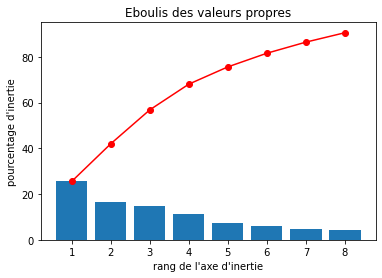

In [23]:
# scree: Contient les pourcentages de l'inertie pour chaque composante 
scree = pca.explained_variance_ratio_*100
# On numérote chaque composante et on affiche ce pourcentage dans un histogramme
plt.bar(np.arange(len(scree))+1, scree)
# On affiche aussi la somme cumulée des pourcentage d'inertie contenue dans chaque composante
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

### Cercle des corrélations

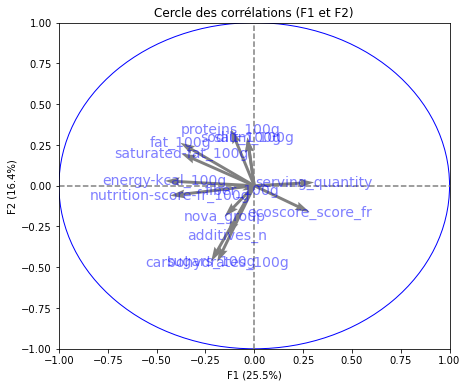

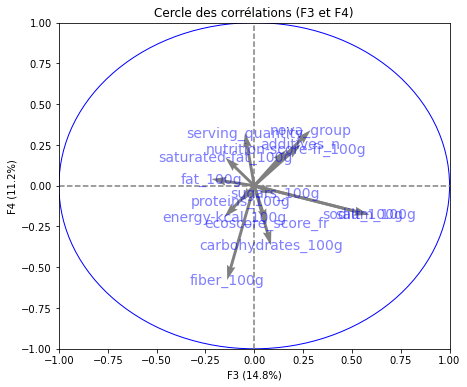

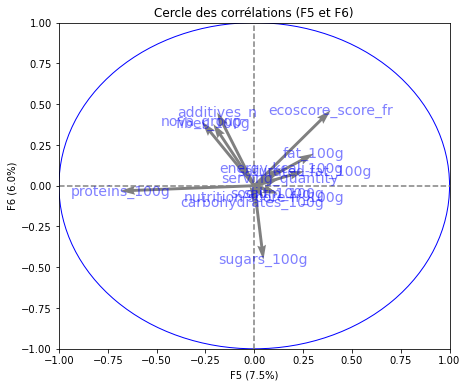

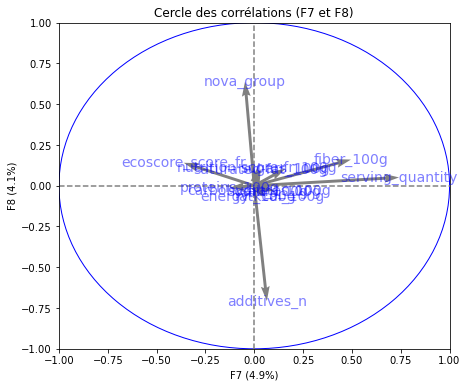

In [24]:
# Les données sont centrées-réduites dont les vecteurs sont normés i.e sur [-1,1]
xmin, xmax, ymin, ymax = -1, 1, -1, 1

def display_corr_circle(d1, d2, pca, labels):
    # pcs: La composition linéaire de chacune des composante principale en fonction de chaque variable
    pcs = pca.components_
    # On crée la figure qui va contenir tous les cercles
    fig, ax = plt.subplots(figsize=(7,6))
    plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
               pcs[d1,:], pcs[d2,:],
               angles='xy', scale_units='xy', scale=1, color="grey")
    # On parcours les segments pour les annoter
    for i, (x, y) in enumerate(pcs[[d1,d2]].T):
        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', color="blue", alpha=0.5)
    # nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
    plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    # On crée un cercle de centre (0,0) et de rayon 1, contenant tous les segments
    circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
    # plt.gca: Permet d'obtenir l'objet Axes de la figure courante, pour ajouter le cercle
    plt.gca().add_artist(circle)
    # affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')
    plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
    
for d1, d2 in [(0, 1), (2, 3), (4, 5), (6, 7)]:
    display_corr_circle(d1, d2, pca, cols_quantity)

plt.show(block=False)

In [25]:
pd.DataFrame(data=pca.components_, columns=cols_quantity, index = [str("F%d" % i) for i in range(1, n_components+1)])

,additives_n,carbohydrates_100g,ecoscore_score_fr,energy-kcal_100g,fat_100g,fiber_100g,nova_group,nutrition-score-fr_100g,proteins_100g,salt_100g,saturated-fat_100g,serving_quantity,sodium_100g,sugars_100g
F1,-0.136553,-0.189751,0.283669,-0.457664,-0.379020,-0.061295,-0.152349,-0.430665,-0.119267,-0.035620,-0.373863,0.306562,-0.035620,-0.220933
F2,-0.302560,-0.467926,-0.161971,0.030097,0.263762,-0.029073,-0.189999,-0.061145,0.347420,0.296361,0.197583,0.020194,0.296359,-0.465083
F3,0.236713,0.085834,0.063439,-0.152640,-0.218959,-0.138641,0.288769,0.164451,-0.069942,0.588057,-0.148067,-0.047507,0.588058,0.104805
F4,0.252548,-0.366358,-0.232526,-0.192213,0.041184,-0.578354,0.341101,0.220240,-0.097881,-0.178237,0.172384,0.323593,-0.178239,-0.048936
F5,-0.189781,-0.008845,0.390781,0.137498,0.304021,-0.210623,-0.267052,0.048084,-0.685342,0.118647,0.255501,0.128604,0.118652,0.046913
F6,0.449739,-0.099567,0.461908,0.107269,0.196773,0.379428,0.392145,-0.072077,-0.031841,-0.047587,0.089228,0.042482,-0.047590,-0.453858
F7,0.064525,0.027156,-0.361008,0.041700,0.057536,0.494967,-0.047334,0.016199,-0.125312,0.100839,0.033404,0.741414,0.100833,0.159308
F8,-0.706742,-0.026034,0.140655,-0.067683,-0.064566,0.160314,0.637937,0.111860,-0.012832,-0.032869,0.101514,0.050767,-0.032863,0.104499


L'axe qui va nous intéresser le plus est l'axe F1, qui est le plus anti-corrélé au nutri-score.
On observe également les composantes les plus corrélées positivement (+) et négativement (-):
- \- : Groupe nova
- \- : Quantité de matières grasses, de sucres, de carbohydrates
- \- : Nombre d'additifs
- \+ : Écoscore

### Projection des individus

In [26]:
sample_size = len(X_projected)
indices = np.random.choice(np.arange(len(X_projected)), size=sample_size)
X_projected_samp = X_projected[indices]

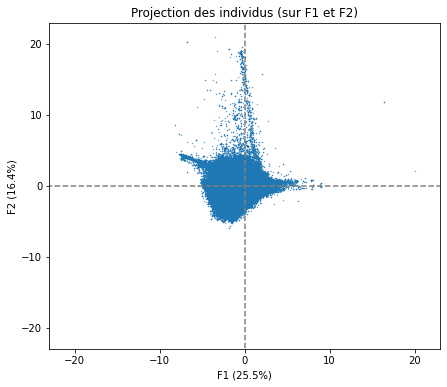

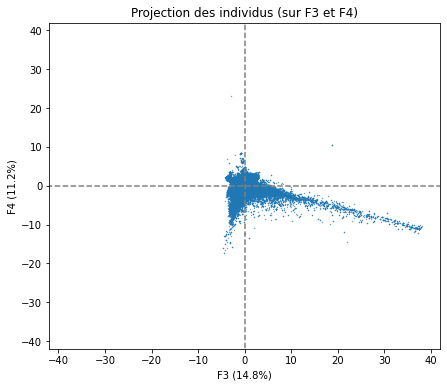

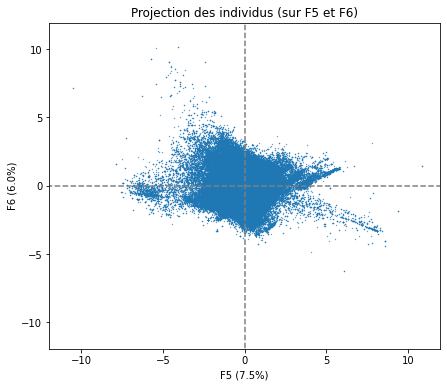

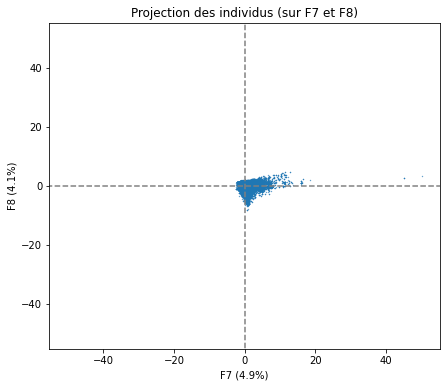

In [27]:
def display_factorial_plane(d1, d2, pca, labels=None, boundary=None):
    # initialisation de la figure   
    fig = plt.figure(figsize=(7,6))
    # affichage des points
    plt.scatter(X_projected_samp[:, d1], X_projected_samp[:, d2], alpha=1, s=0.1)

    if not (labels is None):
        for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
            plt.text(x, y, labels[i], fontsize='14', ha='center',va='center')

    # détermination des limites du graphique
    if boundary is None:
        boundary = np.max(np.abs(X_projected_samp[:, [d1,d2]])) * 1.1
    plt.xlim([-boundary,boundary])
    plt.ylim([-boundary,boundary])

    # affichage des lignes horizontales et verticales
    plt.plot([-100, 100], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-100, 100], color='grey', ls='--')

    # nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
    plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

    plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
    
for d1, d2 in [(0, 1), (2, 3), (4, 5), (6, 7)]:
    display_factorial_plane(d1, d2, pca)

plt.show(block=False)

Dans l'étude des distributions, on avait constaté que les valeurs des variables quantitatives étaient généralement très concentrées autour de certaines valeurs. Cela se traduit dans ces projections par des figures peu étalées dans l'ensemble.

Écart-type: 1.89


Text(0.5, 1.0, "Diagramme en boite des valeurs sur l'axe F1")

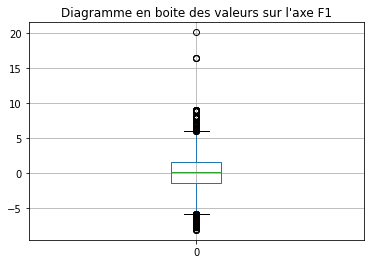

In [30]:
values_F1 = pd.Series(X_projected_samp[:,0])
values_F1.to_frame().boxplot()
print("Écart-type: %.2f" % values_F1.std())
plt.title('Diagramme en boite des valeurs sur l\'axe F1')

In [31]:
Q1 = values_F1.quantile(0.25)
Q3 = values_F1.quantile(0.75)
IQR = Q3-Q1
outliers = values_F1[(values_F1<Q1-1.5*IQR) | (values_F1>Q3+1.5*IQR)]
print("Le diagramme contient %d/%d outliers" % (len(outliers), len(values_F1)))

Le diagramme contient 1196/590357 outliers


On observe pour notre axe principal une moyenne de 0, avec des valeurs concentrée entre -5 et 5. En limitant le score à ces bornes et lui ajoutant 5, on arrive à un score sur 10 pour évaluer la qualité d'un produit.

# Variables qualitatives

## Additifs - Catégories

In [151]:
data_additives = data.dropna(subset=['additives_en'])

In [153]:
cut_additives_en = lambda x: np.array(x.split(','), dtype=str)
additives_lists = data_additives['additives_en'].map(cut_additives_en)

In [154]:
additives_set = list(set(np.hstack(additives_lists)))
print("On a trouvé %d additifs différents" % len(additives_set))

On a trouvé 498 additifs différents


In [155]:
def contains_additive(additive, additives_list):
    if additive in additives_list:
        return 1
    else:
        return 0

In [156]:
frequence_min = 0.5

In [157]:
def count_additives_in_categs(additives_set, categories_name):
    group = pd.DataFrame(index = pd.Index(data_additives[categories_name].unique()))
    for additive in additives_set:
        contains_this_additive = lambda additives_lists: contains_additive(additive, additives_lists)
        data_additives['Number of presence'] = additives_lists.map(contains_this_additive)
        number_of_presence = data_additives[[categories_name, 'Number of presence']].groupby(categories_name).sum()
        group[additive] = number_of_presence['Number of presence']
    return group

In [88]:
pnns_groups_1 = count_additives_in_categs(additives_set, 'pnns_groups_1')
pnns_groups_2 = count_additives_in_categs(additives_set, 'pnns_groups_2')
pnns_groups_1.to_csv("contingency_table_g1_additives.csv", sep='\t')
pnns_groups_2.to_csv("contingency_table_g2_additives.csv", sep='\t')
data_additives.drop(columns=['Number of presence'])

In [89]:
pnns_groups_1 = pd.read_csv("contingency_table_g1_additives.csv", sep='\t', index_col=0)
pnns_groups_2 = pd.read_csv("contingency_table_g2_additives.csv", sep='\t', index_col=0)

In [113]:
to_drop = []
for column in pnns_groups_1.columns:
    inf_to_5 = pnns_groups_1[column] < 5
    if True in inf_to_5.values:
        to_drop.append(column)
pnns_groups_1_ = pnns_groups_1.drop(columns=to_drop)

In [114]:
pnns_groups_1_ = pnns_groups_1_.drop(index=['alcoholic beverages'])

In [115]:
pnns_groups_1_

""
cereals and potatoes
fruits and vegetables
sugary snacks
salty snacks
composite foods
unknown
fat and sauces
beverages
fish meat eggs
milk and dairy products


Malheureusement, le test de khi2 d'indépendance ne peut pas être réalisé ici car il faut une fréquence minimale de 5 dans chaque cellule pour qu'il soit valide. Et, ici, aucune colonne ne vérifie ce critère.

## Groupe nova - Catégorie

In [5]:
X = "nova_group"
Y = "pnns_groups_1"

cont = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
cont = cont.fillna(0)
cont

pnns_groups_1,alcoholic beverages,beverages,cereals and potatoes,composite foods,fat and sauces,fish meat eggs,fruits and vegetables,milk and dairy products,salty snacks,sugary snacks,unknown,Total
nova_group,,,,,,,,,,,,
1.0,5.0,11354.0,19063.0,288.0,959.0,8346.0,13180.0,6693.0,3045.0,665.0,12946.0,76544
2.0,0.0,10.0,319.0,6.0,12518.0,22.0,36.0,12.0,204.0,1147.0,319.0,14593
3.0,9.0,4358.0,14974.0,9393.0,12404.0,20771.0,15292.0,27394.0,9975.0,12704.0,22405.0,149679
4.0,9.0,21145.0,29449.0,31954.0,23920.0,37405.0,8739.0,35735.0,10151.0,91300.0,59734.0,349541
Total,23.0,36867.0,63805.0,41641.0,49801.0,66544.0,37247.0,69834.0,23375.0,105816.0,95404.0,590357


In [6]:
def plot_heat_map(cont):
    tx = cont.loc[:,["Total"]]
    ty = cont.loc[["Total"],:]
    n = len(data)
    indep = tx.dot(ty) / n

    c = cont.fillna(0) # On remplace les valeurs nulles par 0
    measure = (c-indep)**2/indep
    xi_n = measure.sum().sum()
    table = measure/xi_n

    plt.figure(figsize=(16,3))
    sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
    plt.show()
    return table.drop(index=['Total'], columns=['Total'])

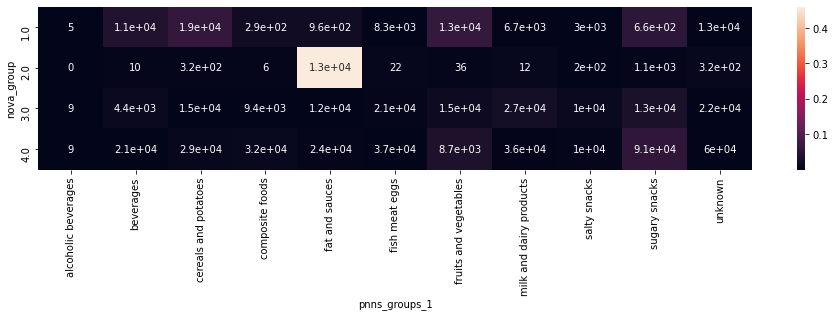

pnns_groups_1,alcoholic beverages,beverages,cereals and potatoes,composite foods,fat and sauces,fish meat eggs,fruits and vegetables,milk and dairy products,salty snacks,sugary snacks,unknown
nova_group,,,,,,,,,,,
1.0,0.000006,0.040214,0.062600,0.021521,0.020823,0.000041,0.064227,0.002739,2.986226e-07,0.055253,0.000119
2.0,0.000003,0.003965,0.004465,0.004525,0.460313,0.007122,0.003781,0.007572,1.075661e-03,0.003668,0.007844
3.0,0.000008,0.011845,0.000398,0.000571,0.000017,0.004009,0.016110,0.023580,1.230150e-02,0.033076,0.000585
4.0,0.000007,0.000095,0.008168,0.009612,0.004674,0.000449,0.035755,0.003389,4.373613e-03,0.058267,0.000830


In [7]:
plot_heat_map(cont)

In [8]:
chi2, p, dof, ex = chi2_contingency(cont.drop(index=['Total'], columns=['alcoholic beverages', 'Total']))
print("chi2: %.2f\np-value: %.2f" % (chi2, p))

chi2: 224811.54
p-value: 0.00


### Nutri-score - Catégorie

In [166]:
bins = [-30, 0, 5, 15, 45]
df = data.copy()
df['nutrition-score-fr_100g'] = pd.cut(df['nutrition-score-fr_100g'], bins)
df['nutrition-score-fr_100g'] = df['nutrition-score-fr_100g'].map(get_left_interval)
df['nutrition-score-fr_100g'] = df['nutrition-score-fr_100g'].astype(float)
X = "nutrition-score-fr_100g"
Y = "pnns_groups_1"

cont = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
cont = cont.fillna(0)
cont

pnns_groups_1,alcoholic beverages,beverages,cereals and potatoes,composite foods,fat and sauces,fish meat eggs,fruits and vegetables,milk and dairy products,salty snacks,sugary snacks,unknown,Total
nutrition-score-fr_100g,,,,,,,,,,,,
-30.0,0.0,5760.0,32049.0,8348.0,3597.0,13485.0,27786.0,12369.0,1999.0,1717.0,15208.0,122318
0.0,11.0,10700.0,13135.0,17673.0,8338.0,18689.0,5609.0,14944.0,4153.0,3477.0,15567.0,112296
5.0,8.0,15776.0,14202.0,12506.0,24174.0,16979.0,3548.0,25925.0,11714.0,37639.0,42392.0,204863
15.0,4.0,4631.0,4419.0,3114.0,13692.0,17391.0,304.0,16596.0,5509.0,62983.0,22237.0,150880
Total,23.0,36867.0,63805.0,41641.0,49801.0,66544.0,37247.0,69834.0,23375.0,105816.0,95404.0,590357


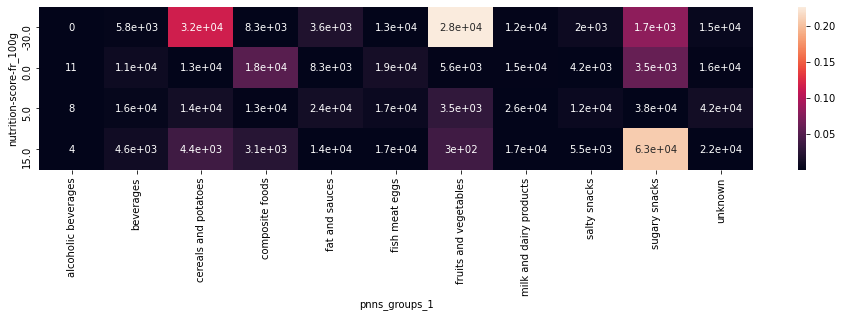

pnns_groups_1,alcoholic beverages,beverages,cereals and potatoes,composite foods,fat and sauces,fish meat eggs,fruits and vegetables,milk and dairy products,salty snacks,sugary snacks,unknown
nutrition-score-fr_100g,,,,,,,,,,,
-30.0,2.071341e-05,0.002008,0.116567,0.000039,0.019031,0.000029,0.226839,0.001325,0.007260,0.080954,0.004570
0.0,4.360571e-05,0.008427,0.000357,0.052189,0.000591,0.012491,0.001337,0.000902,0.000084,0.059873,0.001595
5.0,1.893128e-10,0.003022,0.012374,0.001137,0.011948,0.007033,0.029571,0.000513,0.006954,0.000100,0.011320
15.0,2.608493e-06,0.010590,0.037669,0.023148,0.000317,0.000038,0.038776,0.000382,0.000157,0.207594,0.000821


In [113]:
plot_heat_map(cont)

In [167]:
chi2, p, dof, ex = chi2_contingency(cont.drop(index=['Total'], columns=['alcoholic beverages', 'Total']))
print("chi2: %.2f\np-value: %.2f" % (chi2, p))

chi2: 230047.14
p-value: 0.00


### Sugar - Category

In [114]:
bins = [0, 20, 40, 60, 100]
df = data.copy()
df['sugars_100g'] = pd.cut(df['sugars_100g'], bins)
df['sugars_100g'] = df['sugars_100g'].map(get_left_interval)
df['sugars_100g'] = df['sugars_100g'].astype(float)
X = "sugars_100g"
Y = "pnns_groups_1"

cont = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
cont = cont.fillna(0)
cont

pnns_groups_1,alcoholic beverages,beverages,cereals and potatoes,composite foods,fat and sauces,fish meat eggs,fruits and vegetables,milk and dairy products,salty snacks,sugary snacks,unknown,Total
sugars_100g,,,,,,,,,,,,
0.0,22.0,30316.0,48906.0,38505.0,29644.0,41791.0,29685.0,48888.0,19489.0,15851.0,54394.0,357491
20.0,1.0,869.0,6827.0,642.0,4306.0,304.0,1572.0,4558.0,371.0,41421.0,16894.0,77765
40.0,0.0,389.0,801.0,64.0,942.0,28.0,1896.0,168.0,102.0,34776.0,6570.0,45736
60.0,0.0,506.0,46.0,8.0,132.0,3.0,1906.0,66.0,23.0,11486.0,3928.0,18104
Total,23.0,32080.0,56580.0,39219.0,35024.0,42126.0,35059.0,53680.0,19985.0,103534.0,81786.0,499096


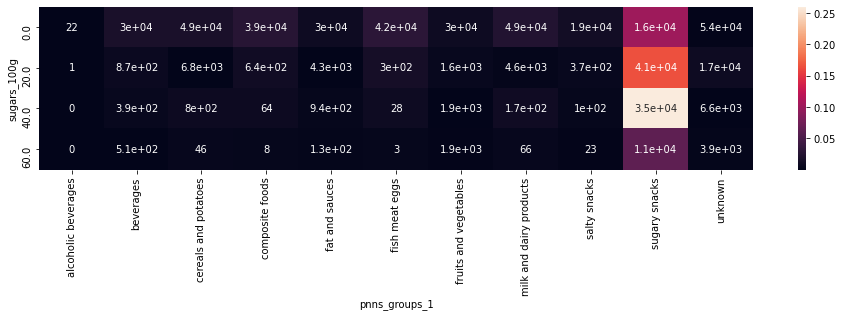

pnns_groups_1,alcoholic beverages,beverages,cereals and potatoes,composite foods,fat and sauces,fish meat eggs,fruits and vegetables,milk and dairy products,salty snacks,sugary snacks,unknown
sugars_100g,,,,,,,,,,,
0.0,0.000014,0.017802,0.018252,0.026736,0.009783,0.030304,0.009819,0.024076,0.013149,0.102067,0.001396
20.0,0.000004,0.007776,0.000153,0.011554,0.000060,0.014457,0.005859,0.002604,0.005666,0.165050,0.010141
40.0,0.000005,0.005156,0.008538,0.008491,0.003372,0.009355,0.000722,0.011167,0.003940,0.260253,0.000025
60.0,0.000002,0.000677,0.004795,0.003461,0.002410,0.003750,0.001873,0.004423,0.001656,0.063442,0.002344


In [115]:
plot_heat_map(cont)

In [168]:
cont = cont.replace(3., 5.)
chi2, p, dof, ex = chi2_contingency(cont.drop(index=['Total'], columns=['alcoholic beverages', 'Total']))
print("chi2: %.2f\np-value: %.2f" % (chi2, p))

chi2: 230047.14
p-value: 0.00
